In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from statannotations.Annotator import Annotator
from glob import glob
import pickle
from collections import defaultdict
import scipy.stats
import re

In [2]:
data_dir = '/s/project/mll/sergey/effect_prediction/MLM/'

In [3]:
motif_preds = pd.read_csv(data_dir + 'motif_predictions/species_aware/conservation_df.csv.gz')

In [4]:
N_species = 241

In [5]:
from matplotlib.colors import ListedColormap,LinearSegmentedColormap

pal = sns.color_palette('mako')

mako = LinearSegmentedColormap.from_list('',pal.as_hex()) #mako

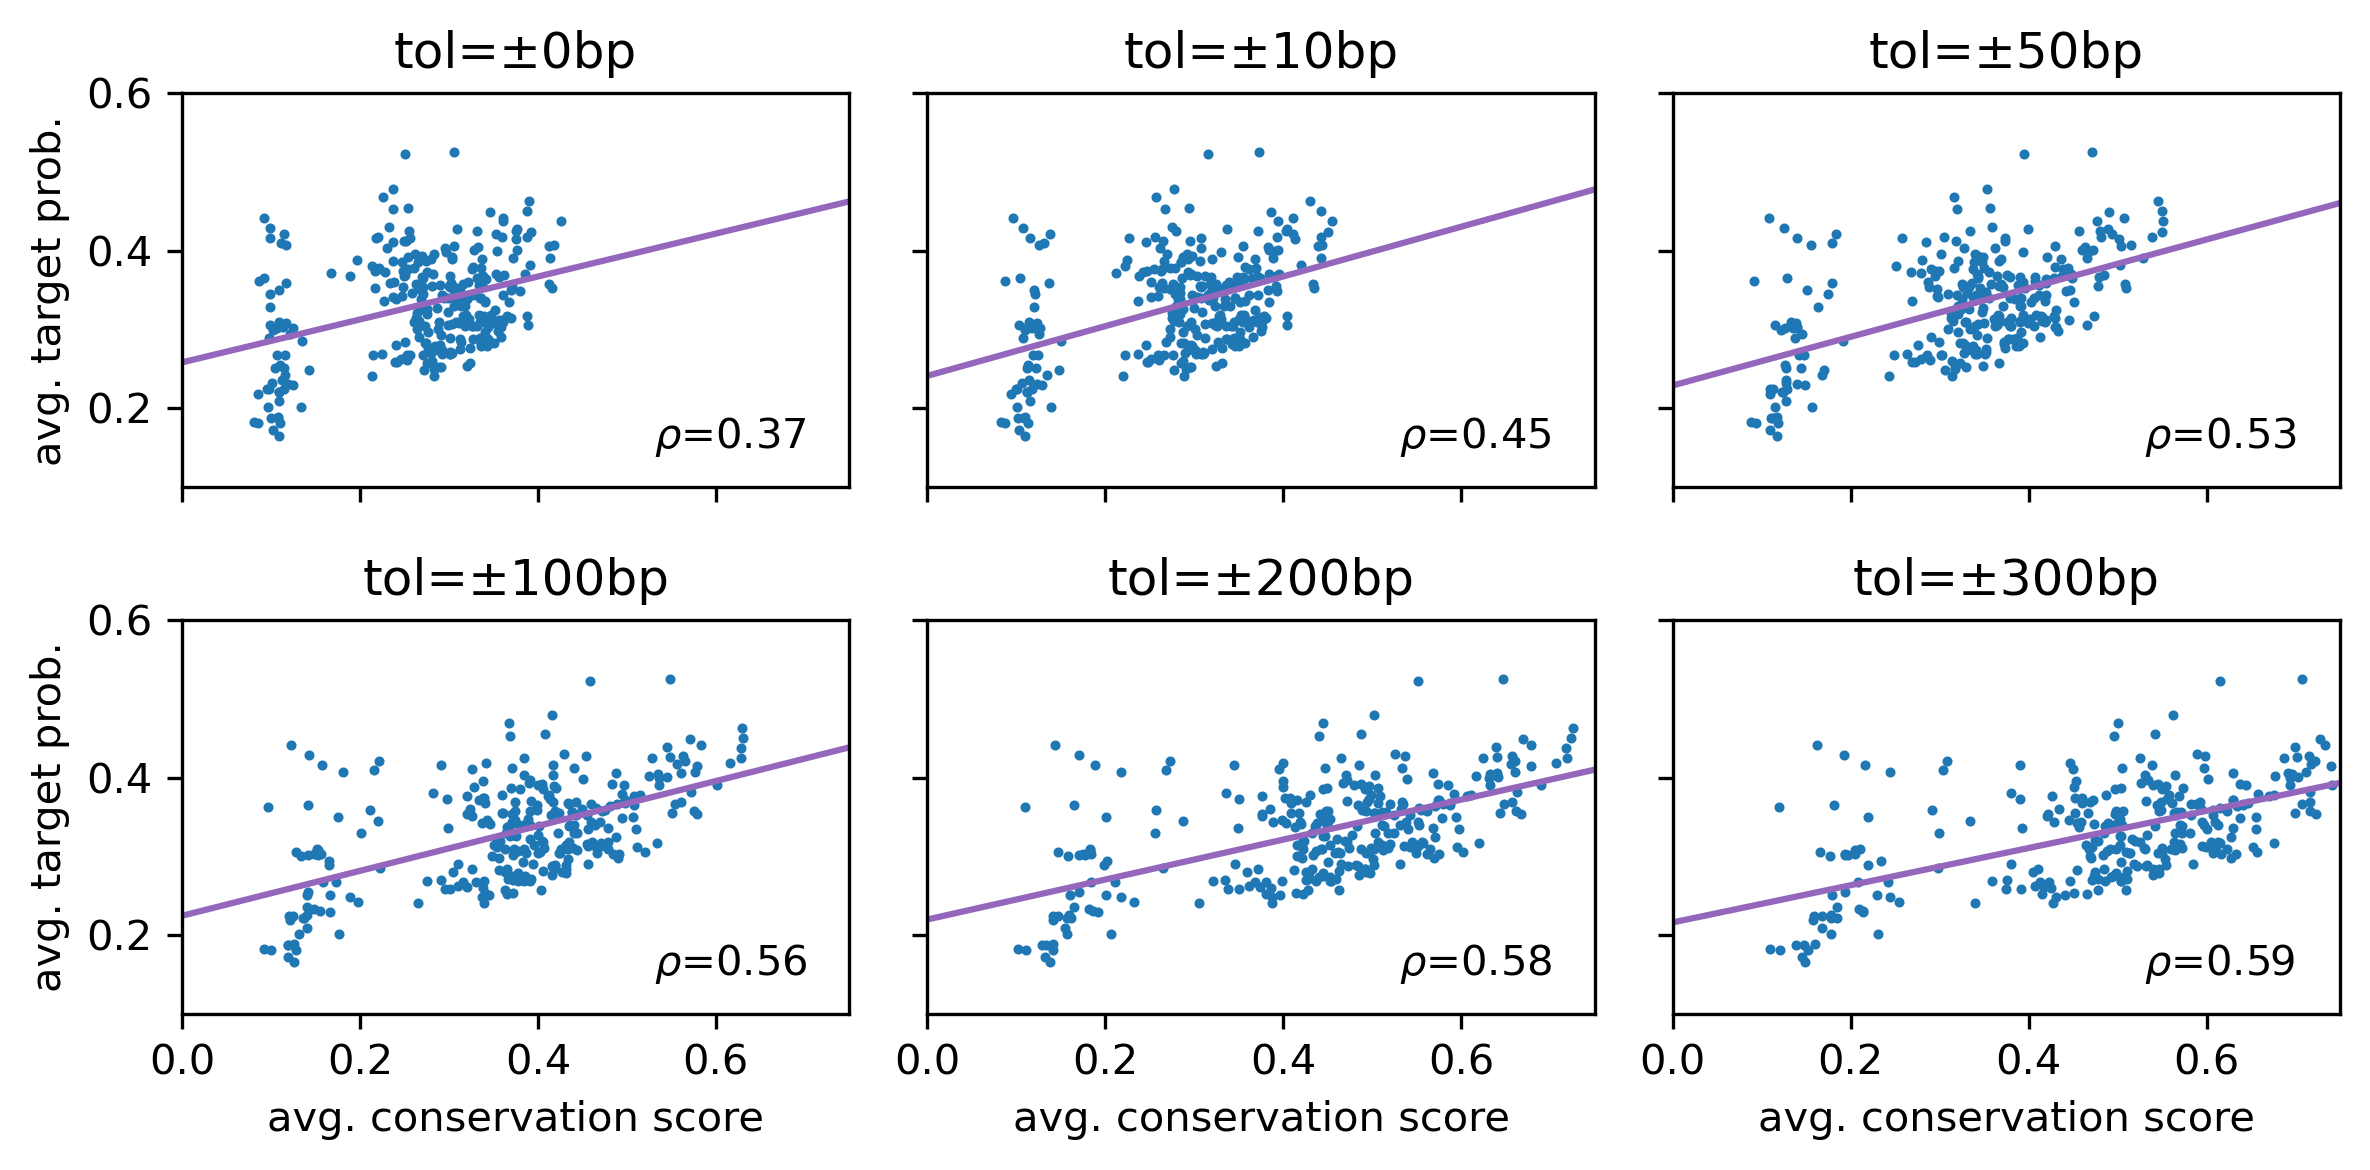

In [6]:
fig, axes = plt.subplots(2,3, figsize=(8,4), dpi=300)

axes = axes.flatten()

for tol,ax_idx in zip((0,10,50,100,200,300),range(6)): 

    ax = axes[ax_idx]
    
    consv_score_column = f'Nmatches_{tol}'

    consv_score_vs_prob = motif_preds.groupby('motif')[['avg_target_prob',  consv_score_column]].mean()
    
    x = consv_score_vs_prob[consv_score_column]/N_species
    y = consv_score_vs_prob.avg_target_prob
    
    #scatter = ax.scatter(x,y, s=2, c = consv_score_vs_prob.motif_entropy, cmap=mako)
    
    #color = ['tab:red' if x in top_motifs.values else 'tab:blue' for x in consv_score_vs_prob.index]
    
    scatter = ax.scatter(x,y, s=2)
    
    pearson_r, p_value = scipy.stats.pearsonr(x,y)
        
    k, b = np.polyfit(x,y,deg=1)
    
    
    ax.plot(np.linspace(0.0,0.75), k*np.linspace(0.0,0.75)+b, c='tab:purple')
    
    ax.text(x=0.53, y=0.15, s=r"$\rho$"+f'={pearson_r:.2f}', fontsize=10)
    
    ax.set_xlim([0,0.75])
    ax.set_ylim([0.1,0.6])
    
    if ax_idx!=0 and ax_idx!=3:
        ax.set_yticklabels([])
    else:
        ax.set_ylabel('avg. target prob.')

    if ax_idx<3:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel('avg. conservation score')
        
    #if ax_idx in (2,5):
    #    divider = make_axes_locatable(ax)
    #    cax = divider.append_axes('right', size='5%', pad=0.05)
    #    cbar = fig.colorbar(scatter, cax=cax, orientation='vertical',label='motif entropy');
        
    ax.set_title(f'tol=±{tol}bp')
        
fig.tight_layout()

In [31]:
def avg_prob_vs_consv(motif, consv_counts = 'Nmatches_200'):

    motif_df = motif_preds.loc[motif_preds.motif==motif,['avg_target_prob',consv_counts]]
    motif_df = motif_df[motif_df[consv_counts]>1] #ex
    motif_df['consv_score'] = motif_df[consv_counts]/N_species

    bin_edges = np.linspace(0,1,21)
    bin_centers = (bin_edges[:-1] + bin_edges[1:])/2

    motif_df['consv_score_bin'] = pd.cut(motif_df.consv_score,bins=bin_edges)

    avg_prob = motif_df.groupby('consv_score_bin').avg_target_prob.agg(['mean','size'])
    
    return bin_centers, avg_prob['mean'], avg_prob['size']

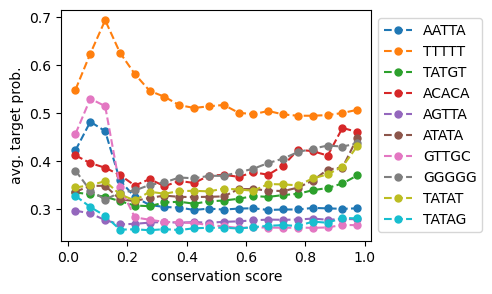

In [52]:
fig, ax = plt.subplots(figsize=(4,3))

for motif in top_motifs.unique()[0:10]:
    
    x, y, size = avg_prob_vs_consv(motif)
    
    ax.plot(x,y,linestyle='--',marker = 'o',markersize=5, label=motif)

ax.set_xlabel('conservation score')
ax.set_ylabel('avg. target prob.')

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#ax.set_ylim([0,1])

# Compare top motifs with Students' result

In [ ]:
avg_prob_motif = motif_preds.groupby('motif').avg_target_prob.mean()

In [100]:
proteins = ['EWSR1','FUS','TAF15','HNRNPL','PABPN1L','TRA2A', 'PCBP2', 'RBFOX2', 'TARDBP', 'PTBP3',
           'CELF1', 'FUBP3', 'KHSRP', 'PUM1', 'KHDRBS2']

In [101]:
selected_proteins = top_motifs.loc[proteins]

In [102]:
df = avg_prob_motif.loc[selected_proteins.values].reset_index()
df['protein'] = proteins

In [106]:
df[['protein','motif','avg_target_prob']]

,protein,motif,avg_target_prob
0,EWSR1,GGGGG,0.365417
1,FUS,GGGGG,0.365417
2,TAF15,GGGGG,0.365417
3,HNRNPL,ACACA,0.382921
4,PABPN1L,AAAAA,0.524158
5,TRA2A,GAAGA,0.330495
6,PCBP2,CCCCC,0.368509
7,RBFOX2,GCATG,0.348494
8,TARDBP,GTATG,0.281759
9,PTBP3,TTTCT,0.415715


# Mobility

In [7]:
motif_preds['mobility'] = motif_preds.Nmatches_200-motif_preds.Nmatches_0

In [8]:
motif_preds[motif_preds.motif_counts_ref==1].sort_values(by='mobility',ascending=False).head(40)

,seq_idx,motif,motif_start,avg_target_prob,Nmatches_0,Nmatches_10,Nmatches_50,Nmatches_100,Nmatches_200,Nmatches_300,motif_entropy,motif_counts_ref,top_motif,mobility
10391438,16880,TGTCT,1386,0.304914,6.0,6.0,6.0,10.0,239.0,239.0,1.370951,1.0,False,233.0
9952869,16217,ATAAA,659,0.483025,7.0,238.0,238.0,238.0,238.0,238.0,0.721928,1.0,True,231.0
3785533,5920,GGTGG,341,0.266909,7.0,238.0,238.0,238.0,238.0,238.0,0.721928,1.0,False,231.0
3775382,5895,GGTGG,341,0.266414,9.0,239.0,239.0,239.0,239.0,239.0,0.721928,1.0,False,230.0
1715978,2848,ACAGT,688,0.327158,4.0,233.0,233.0,233.0,233.0,233.0,1.921928,1.0,False,229.0
4111812,6551,TATAT,285,0.624710,6.0,235.0,235.0,235.0,235.0,235.0,0.970951,1.0,True,229.0
264251,560,TTTAT,31,0.564408,10.0,239.0,239.0,239.0,239.0,239.0,0.721928,1.0,False,229.0
11090985,18111,GTGTT,339,0.339623,2.0,2.0,195.0,197.0,230.0,230.0,0.970951,1.0,False,228.0
1863078,3152,AATAA,1,0.312090,3.0,231.0,231.0,231.0,231.0,231.0,0.721928,1.0,False,228.0
5207931,8686,ATAAA,282,0.406673,1.0,229.0,229.0,229.0,229.0,229.0,0.721928,1.0,True,228.0


In [9]:
def read_fasta(fasta_file):
    
    '''
    Read FASTA file
    sequence names are ignored
    outputs an array of sequences
    '''
    
    fasta_seqs = defaultdict(str)
    
    with open(fasta_file,'r') as f:
        for line in f:
            if line.startswith('>'):
                species = line.split(':')[1]
            else:
                fasta_seqs[species] += line.rstrip().upper()
                
    return fasta_seqs

In [10]:
fasta_path = '/s/project/mll/sergey/effect_prediction/MLM/aligned/data/3_prime_UTR/194/ENST00000338167.10_utr3_16_0_chr11_130143449_f.fa'


fasta_seqs = read_fasta(fasta_path) 

In [34]:
motif = 'ATGTT'
motif_start = 384

tol=50
motif_len = len(motif)

mask = np.ones((len(fasta_seqs),2*tol+motif_len-1))

for seq_idx,seq in enumerate(fasta_seqs.values()):
    seq = seq[motif_start-tol:motif_start+tol+motif_len]
    for match in re.finditer(motif,seq):
        mask[seq_idx,match.start():match.end()] = 0

In [55]:
selected_species_idx = np.zeros((N_species,),dtype=int)
selected_species_idx[1:] = np.random.randint(1,len(fasta_seqs.keys()),size=N_species-1)

for species, seq in np.array(list(fasta_seqs.items()))[selected_species_idx]:
    seq = seq[motif_start-tol:motif_start+tol+motif_len]
    seq_list = list(seq)
    for match in re.finditer(motif,seq):
        seq_list[match.start()] = "\x1b[31m" + seq_list[match.start()]
        seq_list[match.end()-1] = seq_list[match.end()-1] + "\x1b[0m" 
    print(f'{species:<27}',''.join(seq_list))
    
        

Homo_sapiens                GAAATGTCGATTTTCAATAATAGACTTATATGCAGGCTGTCGTTCCGGTTATGTTGTGTAAGTCAACTCTTCAGCCTCATTCACTGTCCTGGCTTTTATTTAAAG
Muscardinus_avellanarius    -AAATGTTGGTTCTCAGTGATAGACTTACGTGCAGGCTGTTGTTCCAGTTATGATATACAAGTCAATTCT-TAGGCTCATCCACTGTCCTAGTTTTTATTTAAAG
Pongo_abelii                GAAATGTCGATTTTCAATAATAGACTTATATGCAGGCTGTCGTTCCGGTTATGTTGTGTAAGTCAACTCTTCAGGCTCATTCACTGTCCTGGCTTTTATTTAAAG
Craseonycteris_thonglongyai AAAATGTTGGTTTTCAATGATAGATTTATATGCCAGTTGTTGTTCCAGTTGCATTGTATAAATCAACTCTTTAGGCTCATTCACTGTCCTGGTTTTTATT-----
Rhinopithecus_roxellana     GAAATGTCGATTTTCAATAATAGACTTATATGCAGGCTGTCGTTCCAGTTACGTTGTGTAAGCCAACTCTTCAGGCTCATTCACTGTCCTGGCTTTTATTTAAAG
Acinonyx_jubatus            GAAATGTTGGTTTTTGGTAATAGACTTATATGCAGGCCG---TTCCAGCTGTATTGTATGCGTCA-CTCCTTTGGCTCATTCACTGTCCCGGTTTTTATTAAAA-
Pteropus_vampyrus           AAAATGTTGATTTTCAATGATAGACTTGTATGCAGGTAGTTGTTCCAGTTGCATTGTATAAATCAACTCTTTAGGCTCATTCACTGTCCTGGGTTTTTTTT----
Pteropus_vampyrus           AAAATGTTGATTTTCAATGATAGACTTGTATGCA

/scratch/tmp/l_vilov/ipykernel_972971/2728247608.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels((ax.get_xticks()-tol).astype(int))


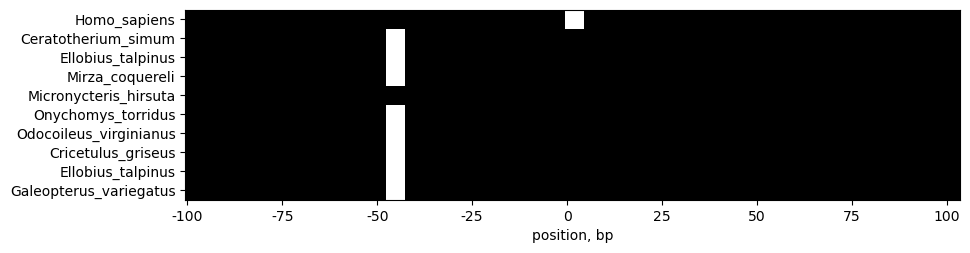

In [229]:
N_species = 10

selected_species_idx = np.zeros((N_species,),dtype=int)
selected_species_idx[1:] = np.random.randint(1,len(fasta_seqs.keys()),size=N_species-1)

#selected_species_idx = list(range(0,len(fasta_seqs),len(fasta_seqs)//N_species))[:N_species]

fig, ax = plt.subplots(figsize=(10,4))

ax.imshow(mask[selected_species_idx],cmap='Greys', interpolation='none')
ax.set_yticks(range(N_species))
ax.set_yticklabels(np.array(list(fasta_seqs.keys()))[selected_species_idx])

ax.set_xticklabels((ax.get_xticks()-tol).astype(int))

ax.set_xlabel('position, bp')
ax.set_aspect(5)